# Introduction to Aquila

In the previous notebook, we have introduced the concept of Analog Hamiltonian Simulation (AHS) and how to run an AHS program on a Rydberg-based local simulator. In this notebook, we will illustrate how to run an AHS program on QuEra's Aquila, a Rydberg based QPU, via Amazon Braket. 


Some feedback on notebook 01:
Let's start with the device, similar to here: https://quip-amazon.com/CQlFApD7TGPU/Run-your-2nd-Analog-Hamiltonian-Simulation-workload
connect to it, get name, get capabilities, show how to understand those capabilities
When mentioning the constraints on atom array and time series, explicitly call out the corresponding device capability variables names (not only the numerical values).
Make all cells runable, and verify that they do run (except the "Result" section for now)

move device section up to the first part.


bring up the capability dict, they may change

## Introduction to Aquila

We query the Aquila QPU on the Braket service using its unique Amazon Resource Number (ARN).

In [17]:
from braket.aws import AwsDevice 

device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
print(device)

Device('name': Aquila, 'arn': arn:aws:braket:us-east-1::device/qpu/quera/Aquila)


In [18]:
# [Optional] We print values to the screen for inspection by a human

import json
# capabilities = json.loads(device.properties.paradigm.json())
capabilities = capabilities = device.properties.paradigm

In [19]:
# [Optional] We print values and detailed description of one particular section

section = device.properties.paradigm.lattice.geometry
print(type(section))
print(section)
print(section.__doc__)

<class 'braket.device_schema.quera.quera_ahs_paradigm_properties_v1.Geometry'>
spacingRadialMin=Decimal('0.000004') spacingVerticalMin=Decimal('0.000004') positionResolution=Decimal('1E-7') numberSitesMax=256

    Spacing or number of sites or rows
    Attributes:
        spacingRadialMin (Decimal): Minimum radial spacing between any
            two sites in the lattice (measured in meters)
        spacingVerticalMin (Decimal): Minimum spacing between any two
            rows in the lattice (measured in meters)
        positionResolution (Decimal): Resolution with which site positions
            can be specified (measured in meters)
        numberSitesMax (int): Maximum number of sites that can be placed
            in the lattice
    


## Running an AHS program on Aqulia

We have seen the basic components of an AHS program in the previous example, including the register, the driving and shifting fields. In order to run an AHS program on Aquila, however, these components have to meet certain requirements. Particularly, the first version of Aquila will not support shifting field. In this section, we will introduce other constraints via building up a valid program for Aquila step by step. 

### Register

In contrast to the local simulator which can only simulate a handful of atoms, Aquila can support up to 100 atoms. The coordinates of the atoms, however, have to meet the following constraints 

1. The rows of the setup has to be separated by `capabilities.lattice.xx`
2. The atom has to be separated by xx meters
3. The atom coordinates have to have maximum resolution xx meters
4. The registers have to be within a bounding box, which is xx meters wide and xx meters tall

Below, we demonstrate a valid setup that meets these requirements.



In [20]:
capabilities.lattice

Lattice(area=Area(width=Decimal('0.000075'), height=Decimal('0.0001')), geometry=Geometry(spacingRadialMin=Decimal('0.000004'), spacingVerticalMin=Decimal('0.000004'), positionResolution=Decimal('1E-7'), numberSitesMax=256))

In [21]:
capabilities.geometry

AttributeError: 'QueraAhsParadigmProperties' object has no attribute 'geometry'

In [22]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement, SiteType

from utils import show_register

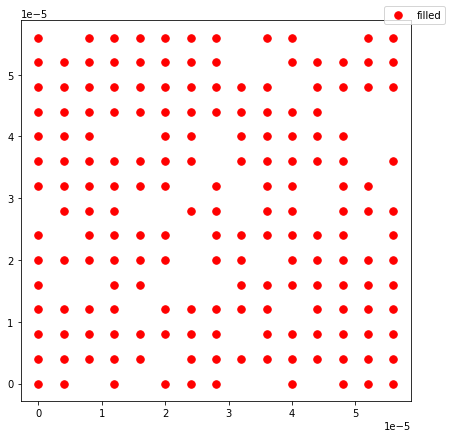

In [23]:
separation = 4e-6  # in meters 
k_max = 15
m_max = 15
vacancies = {
    (0, 1), (0, 8), (0, 11), (0, 12),
    (1, 8), (1, 9),
    (2, 10),
    (3, 12), (3, 13), (3, 14),
    (4, 3), (4, 4), (4, 7), (4, 13), (4, 14),
    (5, 7), (5, 13),
    (6, 6), (6, 8), (6, 11), (6, 14),
    (7, 0), (7, 4), (7, 5), (7, 8), (7, 11),
    (8, 1), (8, 6), (8, 13),
    (9, 6), (9, 9),
    (10, 1), (10, 2), (10, 5), (10, 6), (10, 7),
    (11, 4), (11, 10),
    (12, 8),
    (13, 5),
    (14, 2), (14, 4), (14, 8), (14, 9), (14, 11)
}
register = AtomArrangement()
for k in range(k_max):
    for m in range(m_max):
        if (k, m) not in vacancies:
            register.add((m * separation, (k_max-k-1) * separation))  # site_type is SiteType.FILLED by default
#         else:
#             register.add((m * separation, (k_max-k-1) * separation), site_type=SiteType.VACANT)

show_register(register, show_atom_index=False)

### Driving field

Aquila can simulate the following Hamiltonian 

\begin{align}
H(t) = \sum_{k=1}^N H_{\text{drive}, k}(t) + \sum_{j=1}^N\sum_{k = j}^N H_{\text{vdW}, j, k}.
\end{align}
Here the second term is the interaction term which is fixed once the setup is defined, and the first term is the driving field,
\begin{align}
H_{\text{drive}, k}(t) = \frac{\Omega(t)}{2}\left(e^{i\phi(t)}\sigma_k + e^{-i\phi(t)}\sigma_k^\dagger\right) - \Delta_\text{global}(t)n_k,
\end{align}
which act on all the atoms in the setup. A valid driving field for Aquila has to satisfy a set of requirements. 

For the amplitude of the Rabi frequency $\Omega(t)$, 
1. It has to start and end at 0 rad/s
2. The values have to be within the range of 
3. The values have to have maximum resolution of xx 

and for the phase of the Rabi frequency $\phi(t)$, 
1. It has to start at 0 rad/s
2. The values have to be within the range of 
3. The values have to have maximum resolution of xx 

and for the detuning $\Delta(t)$, 
1. The values have to be within the range of 
2. The values have to have maximum resolution of xx 

For all these fields, 
1. The time points have to start from zero
2. The time points have to have certain resolution xx
3. The time points have to sorted ascendinly
4. The time points have to be separated by at least xx seconds
5. The number of time points has to be the same as that of values
6. The maximum duration of the program 
7. All the fields have to end at the same time points

Below, we demonstrate a valid driving field for Aquila

In [31]:
from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

amplitude_min = 0          # rad / s
amplitude_max = 25000000/4   # rad / s

detuning_min = -125000000  # rad / s
detuning_max = 125000000   # rad / s

time_max = 4e-6  # s
time_ramp = 1e-7  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 16.89, -78.1, 34.8]

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = TimeSeries()
for t, v in zip(time_points, detuning_values):
    detuning.put(t, v)

phase = TimeSeries()
for t, v in zip(time_points, phase_values):
    phase.put(t, v)

# Note: Since all attributes of QuEra Aquila's driving field are uniform,
#       we pass the TimeSeries objects directly to the constructor.
#       This will contruct braket.ahs.field.Field objects with uniform patterns for the attributes.
drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)


We can inspect the driving field in the following way 

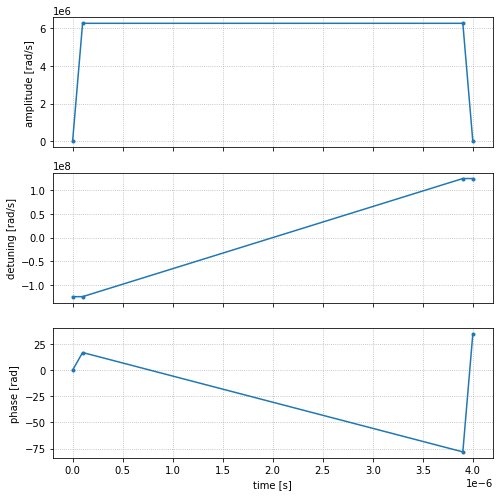

In [32]:
from utils import show_global_drive
show_global_drive(drive)

### AHS program

We can assemble the register and Hamiltonian to an AHS program 

In [33]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

hamiltonian = Hamiltonian()
hamiltonian += drive

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=hamiltonian
)

### Task <a class="anchor" id="task"></a>
[back to top](#TOC)

The AHS program can be submitted to the device to create a quantum task on the Braket service.

In [34]:
# To ensure that the program complies with resolution-specific validation rules

discretized_ahs_program = ahs_program.discretize(device)

In [35]:
# [Optional] Compare original and discretized AHS programs

for original, discretized in zip (
    ahs_program.hamiltonian.terms[0].amplitude.time_series.times(),
    discretized_ahs_program.hamiltonian.terms[0].amplitude.time_series.times(),
):
    print(original.__repr__(), discretized.__repr__())

0 Decimal('0E-9')
1e-07 Decimal('1.00E-7')
3.9e-06 Decimal('0.000003900')
4e-06 Decimal('0.000004000')


In [36]:
task = device.run(discretized_ahs_program, shots=100)
print(task)

AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:545821822555:quantum-task/e22cc630-df02-4cf5-b3fc-e46174f5ca43')


In [39]:
# [Optional] We can investigate task metadata

metadata = task.metadata()
task_arn = metadata['quantumTaskArn']
task_status = metadata['status']

print(f"ARN: {task_arn}")
print(f"status: {task_status}")

ARN: arn:aws:braket:us-east-1:545821822555:quantum-task/e22cc630-df02-4cf5-b3fc-e46174f5ca43
status: CREATED


In [41]:
# Optionally, in a new python session

from braket.aws import AwsQuantumTask

saved_task_arn = "arn:aws:braket:us-east-1:545821822555:quantum-task/e22cc630-df02-4cf5-b3fc-e46174f5ca43"

task = AwsQuantumTask(arn=saved_task_arn)
metadata = task.metadata()
task_arn = metadata['quantumTaskArn']
task_status = metadata['status']

print(f"ARN: {task_arn}")
print(f"status: {task_status}")

ARN: arn:aws:braket:us-east-1:545821822555:quantum-task/e22cc630-df02-4cf5-b3fc-e46174f5ca43
status: CREATED


You can access the tasks through [https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/tasks](this link)

## 6. Result <a class="anchor" id="result"></a>
[back to top](#TOC)

The results (once the task is completed) can be downloaded directly into an object in the python session.

In [ ]:
result = task.result()

result_dict = dict(braket_results.json())

The call `task.result()` is blocking execution until the task is completed and results are loaded from Amazon Braket. The `result_dict` dictionary has the following structure (Disclaimer: sizes and values are not representative of the particular `task` object at hand in the example). 

for presequence, 1 is for ground, 0 for empty

for postsequence, 1 is for ground, 0 for Rydberg or empty.

